In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


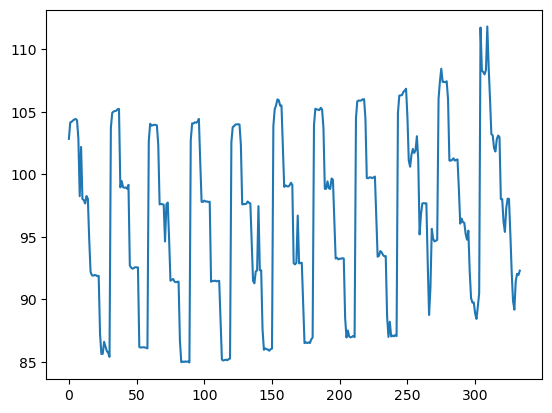

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
 
df = pd.read_csv('project_c.csv')
timeseries = df[["cost"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

In [2]:
timeseries

array([[102.84626 ],
       [104.156   ],
       [104.20741 ],
       [104.31881 ],
       [104.389565],
       [104.43903 ],
       [104.3346  ],
       [102.86384 ],
       [ 98.25982 ],
       [102.19995 ],
       [ 98.03042 ],
       [ 97.950165],
       [ 97.67699 ],
       [ 98.27018 ],
       [ 98.05318 ],
       [ 94.827385],
       [ 92.205475],
       [ 91.93294 ],
       [ 91.89745 ],
       [ 91.953094],
       [ 91.93025 ],
       [ 91.862495],
       [ 91.88834 ],
       [ 87.2484  ],
       [ 85.62881 ],
       [ 85.65541 ],
       [ 86.606316],
       [ 86.222565],
       [ 85.87101 ],
       [ 85.73627 ],
       [ 85.40865 ],
       [103.73415 ],
       [104.92555 ],
       [105.03283 ],
       [105.07019 ],
       [105.09171 ],
       [105.21617 ],
       [105.24092 ],
       [ 98.967445],
       [ 99.461876],
       [ 98.97653 ],
       [ 98.93628 ],
       [ 98.9541  ],
       [ 98.86221 ],
       [ 99.16586 ],
       [ 92.70657 ],
       [ 92.538345],
       [ 92.4

In [3]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=12, num_layers=1, batch_first=True)
        self.linear = nn.Linear(12, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [5]:
lookback = 60

In [6]:
# train-test split for time series
train_size = int(len(timeseries[:304-lookback-15]))
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
print(train_size, test_size)

229 105


In [7]:
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

C:\Users\Jackyfirst\AppData\Local\Temp\ipykernel_3456\778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


In [8]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 3000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 95.1992, test RMSE 99.2102
Epoch 100: train RMSE 71.5246, test RMSE 75.5130
Epoch 200: train RMSE 52.2680, test RMSE 56.2187
Epoch 300: train RMSE 34.4287, test RMSE 38.2951
Epoch 400: train RMSE 18.8989, test RMSE 22.4993
Epoch 500: train RMSE 8.9766, test RMSE 11.3687
Epoch 600: train RMSE 7.4306, test RMSE 8.0366
Epoch 700: train RMSE 5.4933, test RMSE 6.2279
Epoch 800: train RMSE 3.8724, test RMSE 4.0434
Epoch 900: train RMSE 3.5799, test RMSE 3.7058
Epoch 1000: train RMSE 3.4981, test RMSE 3.5672
Epoch 1100: train RMSE 3.4594, test RMSE 3.5914
Epoch 1200: train RMSE 3.4398, test RMSE 3.5462
Epoch 1300: train RMSE 3.4132, test RMSE 3.5971
Epoch 1400: train RMSE 3.3899, test RMSE 3.5863
Epoch 1500: train RMSE 3.2370, test RMSE 3.4788
Epoch 1600: train RMSE 2.9695, test RMSE 3.5324
Epoch 1700: train RMSE 2.7782, test RMSE 3.6196
Epoch 1800: train RMSE 2.6191, test RMSE 3.7319
Epoch 1900: train RMSE 2.4649, test RMSE 4.0406
Epoch 2000: train RMSE 2.3815, test RMSE 

In [9]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

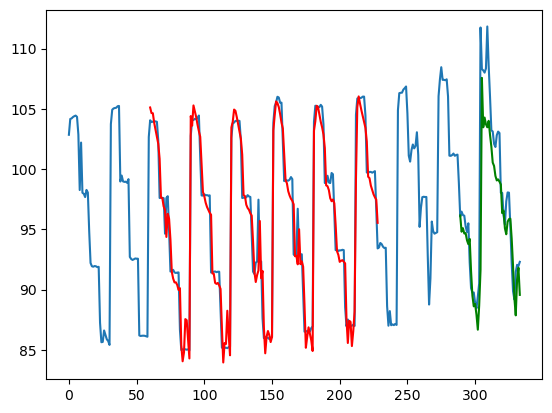

In [10]:
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

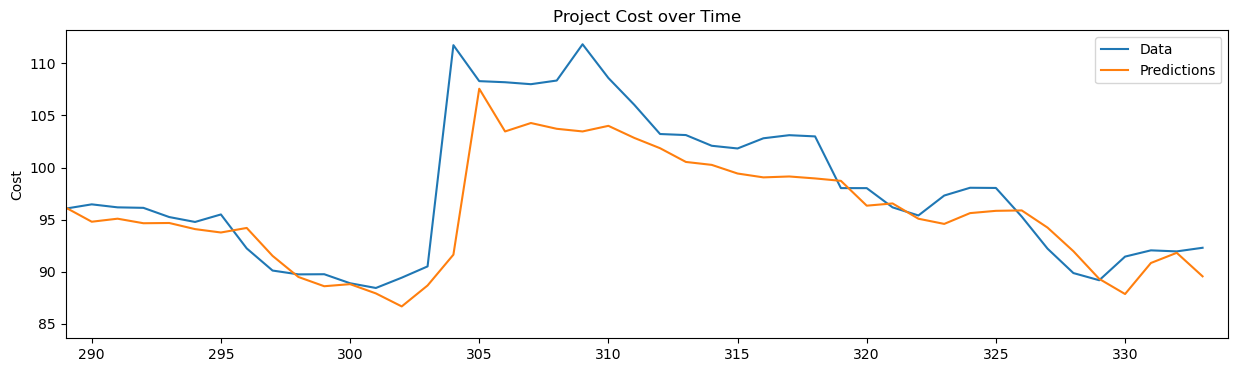

In [11]:
# plot
plt.figure(figsize=(15,4))
plt.plot(timeseries)
plt.plot(test_plot)
plt.legend(('Data', 'Predictions'))
plt.title('Project Cost over Time')
plt.ylabel('Cost')
plt.xlim(train_size + lookback, len(timeseries))
plt.show()